### Joshua Silva

In [1]:
import csv
import sqlite3
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as sp
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#Seaborn uses a scipy.stats function which causes a future warning

## Cleaning and generalizing the indication data, look at the relatoionship between the features and indication

In [ ]:
conn = sqlite3.connect('project.db')
c = conn.cursor()

In [3]:
c.execute('SELECT * FROM indication')
indication_data = c.fetchall()

In [24]:
# There are many possible indications and not alot of data for each
print(len(set([i[1] for i in indication_data])))
print(len(indication_data))

550
2824


In [17]:
# 790 of the types are specified by a (, e.g. Antibacterial (Topical) <- not an actual indication
sum([("(" in i[1]) for i in indication_data])

790

In [29]:
# reducing the complexity of the indication cuts indications in half, removing specifiers and whitespace
simple_ind = list(map(lambda x: x[1].split("(")[0].rstrip().lstrip(), indication_data))
counts = list()
for i in set(simple_ind):
    counts.append([i, simple_ind.count(i)])
counts.sort(key=lambda x: x[1], reverse=True)
counts # certain thereputic areas have more approved drugs than others

[['Antibacterial', 243],
 ['Diagnostic Aid', 134],
 ['Radioactive Agent', 117],
 ['Antineoplastic', 111],
 ['Antihypertensive', 108],
 ['Analgesic', 85],
 ['Pharmaceutic Aid', 77],
 ['Anti-Inflammatory', 72],
 ['Antidepressant', 61],
 ['Glucocorticoid', 55],
 ['Anesthetic', 55],
 ['Antihistaminic', 53],
 ['Antipsychotic', 48],
 ['Antiviral', 45],
 ['Vasodilator', 44],
 ['Anticholinergic', 43],
 ['Sedative-Hypnotic', 42],
 ['Adrenergic', 39],
 ['Anti-Adrenergic', 36],
 ['Anticonvulsant', 36],
 ['Inhibitor', 35],
 ['Antifungal', 34],
 ['Diuretic', 33],
 ['Anti-Emetic', 32],
 ['Relaxant', 32],
 ['Cardiac Depressant', 31],
 ['Bronchodilator', 28],
 ['Anti-Infective', 27],
 ['Cholinergic', 26],
 ['Neuromuscular Blocking Agent', 25],
 ['Topical', 25],
 ['Antidiabetic', 23],
 ['Stimulant', 22],
 ['Antiparkinsonian', 22],
 ['Antagonist', 21],
 ['Vitamin', 21],
 ['Enzyme Inhibitor', 20],
 ['Replenisher', 19],
 ['Antitussive', 19],
 ['Antimalarial', 18],
 ['Tranquilizer', 18],
 ['Progestin', 18]

In [30]:
# The simple indication name is more useful, save this to the DB
c.execute("""ALTER TABLE indication ADD simple_ind text""")
conn.commit()

In [73]:
combined_inds = list()
for i, j in zip(indication_data, simple_ind):
    combined_inds.append(list(i) + [j])

In [76]:
c.execute("""DELETE FROM indication""")
c.executemany("""INSERT INTO indication VALUES (?,?,?)""", combined_inds)
conn.commit()

In [77]:
c.execute('SELECT * FROM molecule')
molecule_data = c.fetchall()

In [81]:
molecule_df = pd.DataFrame(molecule_data,
                      columns = ['chirality', 'id','acd_logd', 'acd_logp', 'acd_most_apka',
                                 'acd_most_bpka', 'alogp', 'aromatic_rings','full_molformula',
                                 'full_mwt', 'hba', 'hbd', 'heavy_atoms', 'molecular_species',
                                 'qed_weighted'])

In [93]:
# Looking at visualizations for the indications which have over 50 drugs for them like ~10
top_indications = [i[0] for i in filter(lambda x: x[1] > 50, counts)]
drugs_in_top = list(filter(lambda x: x[2] in top_indications, combined_inds))
indication_df = pd.DataFrame(drugs_in_top)
indication_df.drop(1, axis = 1, inplace=True)
indication_df.drop_duplicates(0, inplace=True)
indication_df.columns = ['id', 'indication']

In [118]:
joined_df = molecule_df.merge(indication_df, on='id', how='inner')

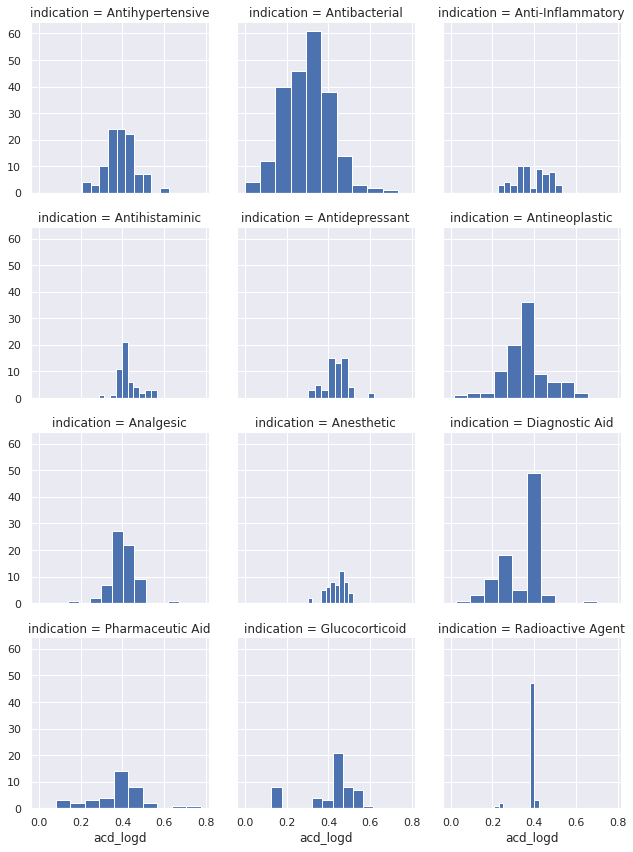

In [137]:
# Each chart in this section is of the quantitative variable specified in the grid.map() line
# Each chart is for a different indication
sns.set()
grid = sns.FacetGrid(joined_df, col='indication', col_wrap=3)
grid.map(plt.hist, "acd_logd")

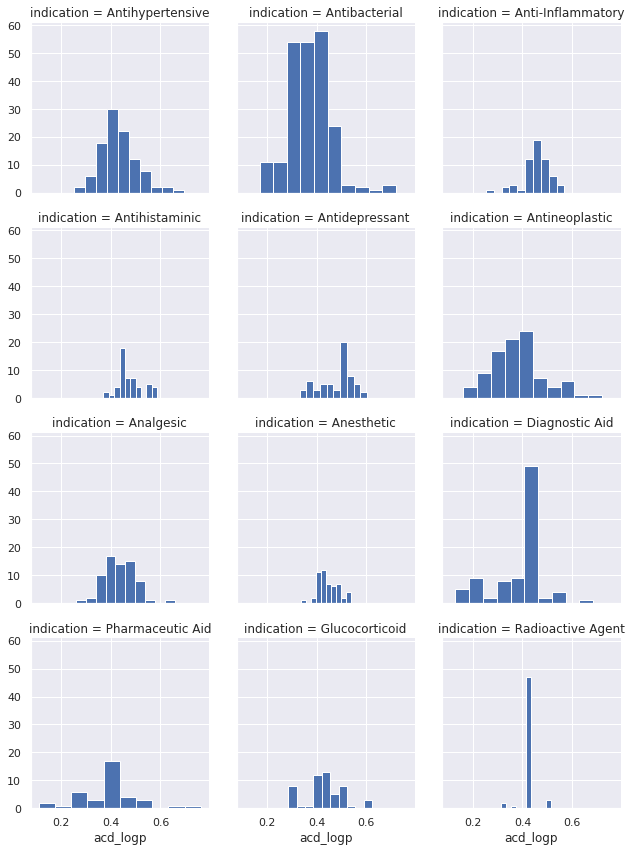

In [138]:
grid = sns.FacetGrid(joined_df, col='indication', col_wrap=3)
grid.map(plt.hist, "acd_logp")

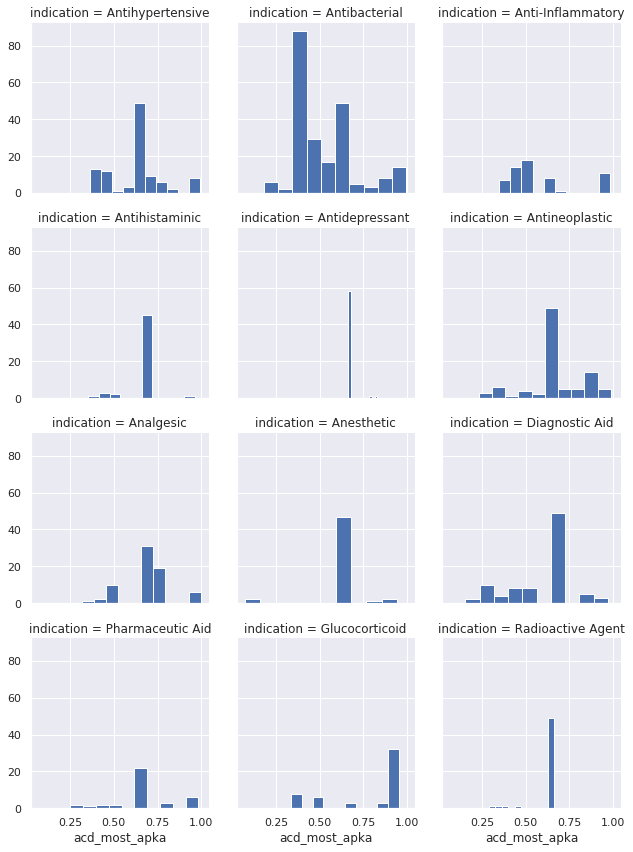

In [139]:
grid = sns.FacetGrid(joined_df, col='indication', col_wrap=3)
grid.map(plt.hist, "acd_most_apka")

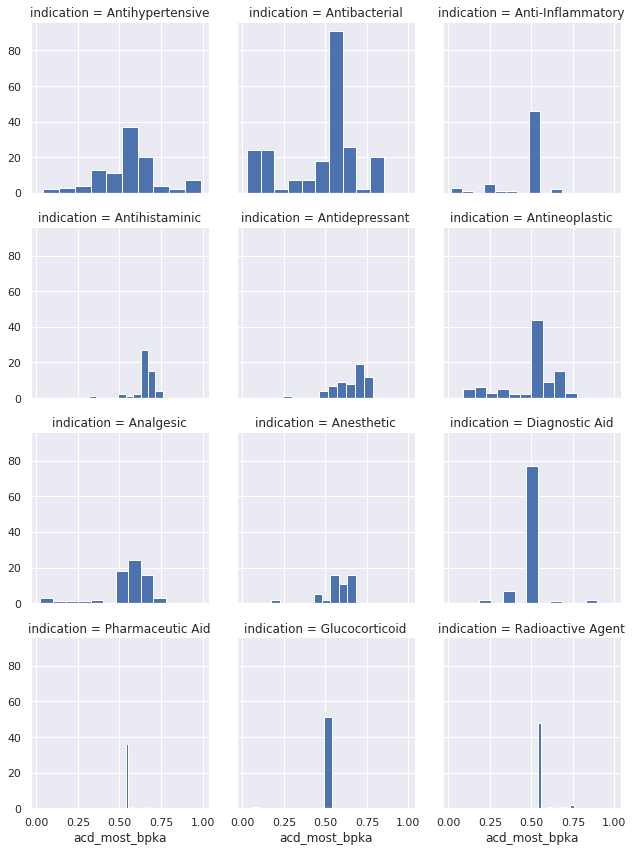

In [140]:
grid = sns.FacetGrid(joined_df, col='indication', col_wrap=3)
grid.map(plt.hist, "acd_most_bpka")

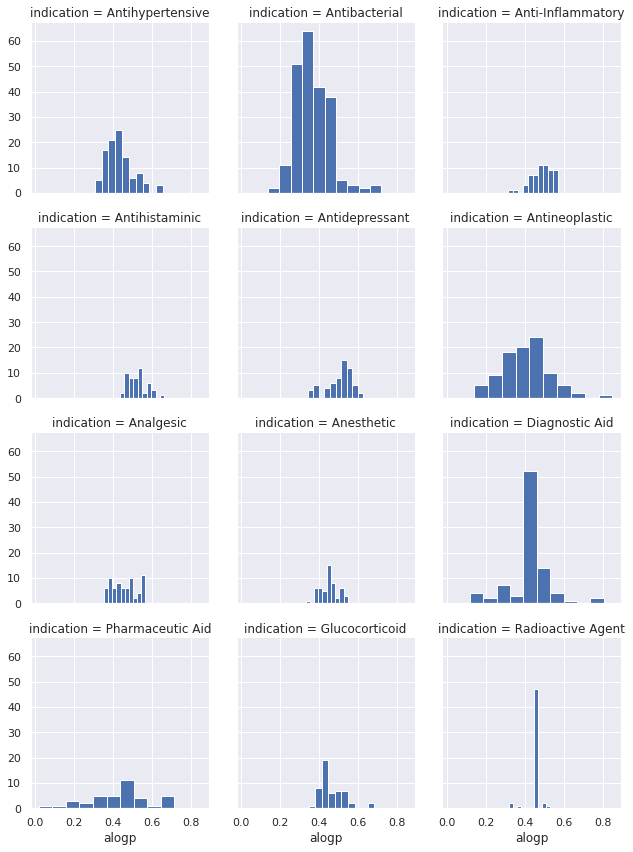

In [142]:
grid = sns.FacetGrid(joined_df, col='indication', col_wrap=3)
grid.map(plt.hist, "alogp")

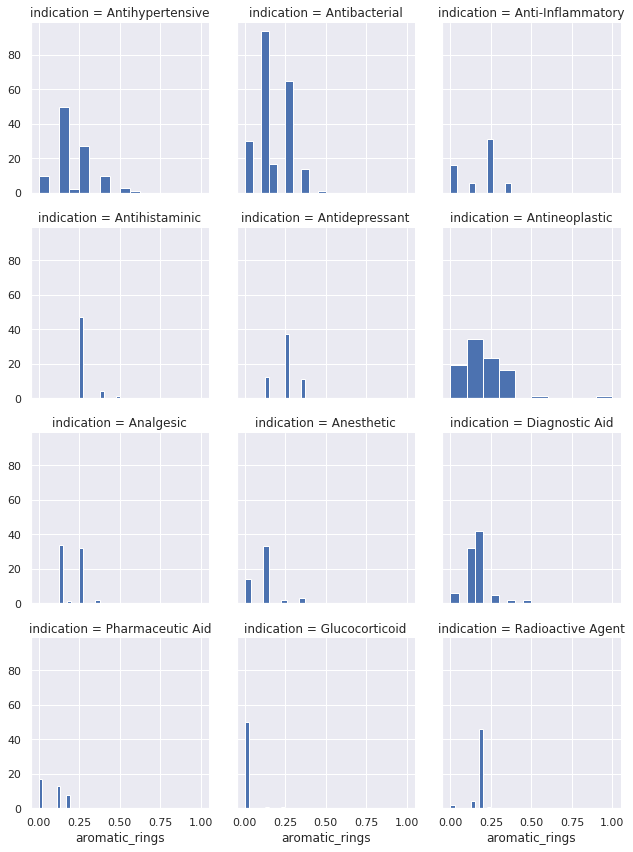

In [143]:
grid = sns.FacetGrid(joined_df, col='indication', col_wrap=3)
grid.map(plt.hist, "aromatic_rings")

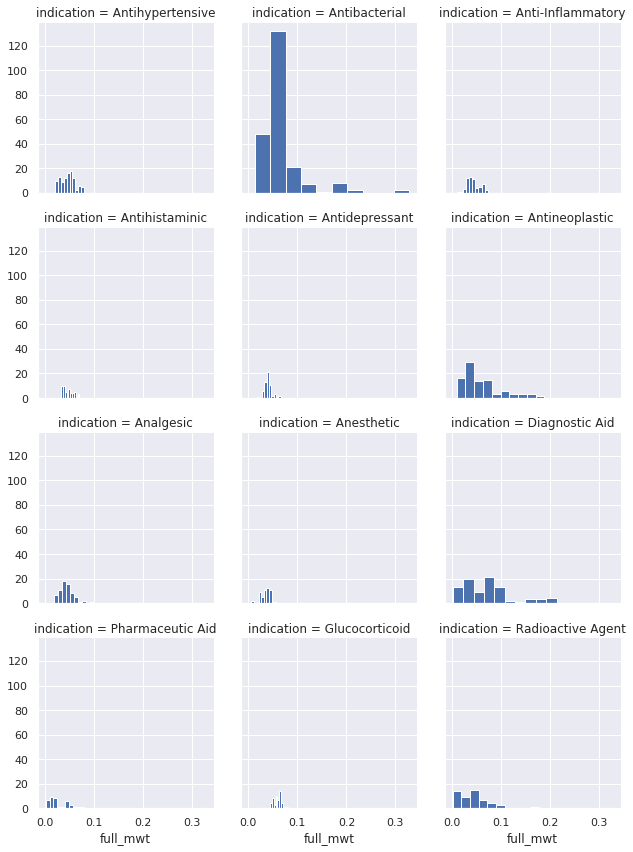

In [144]:
grid = sns.FacetGrid(joined_df, col='indication', col_wrap=3)
grid.map(plt.hist, "full_mwt")

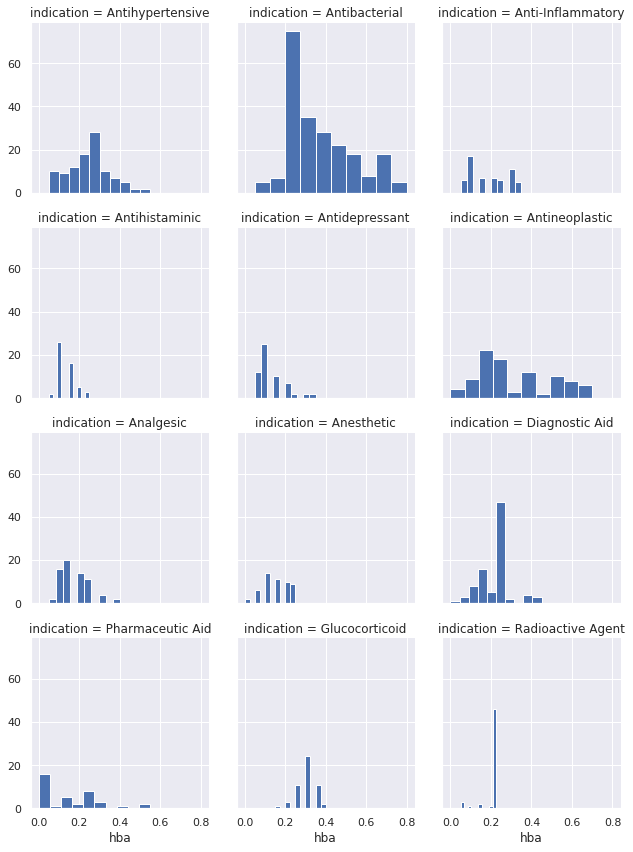

In [145]:
grid = sns.FacetGrid(joined_df, col='indication', col_wrap=3)
grid.map(plt.hist, "hba")

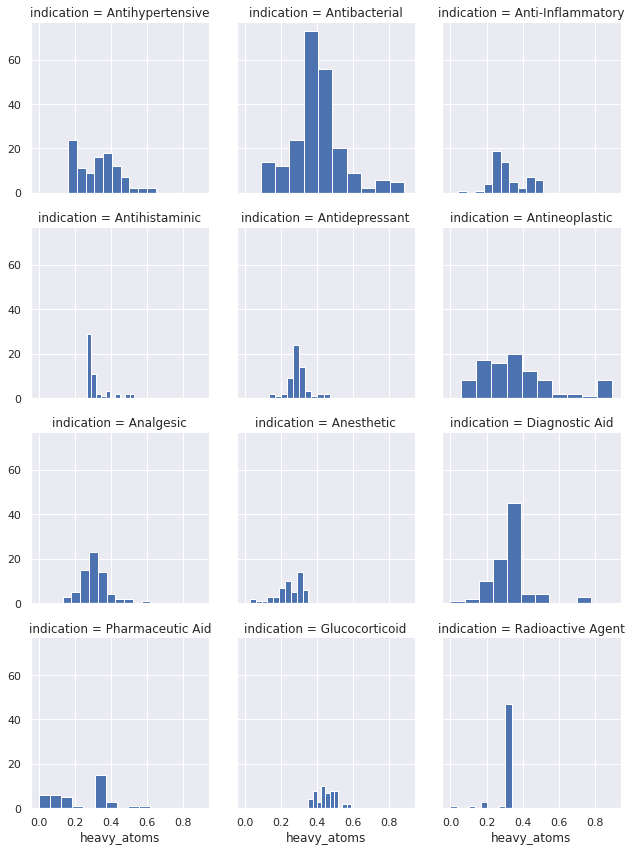

In [146]:
grid = sns.FacetGrid(joined_df, col='indication', col_wrap=3)
grid.map(plt.hist, "heavy_atoms")

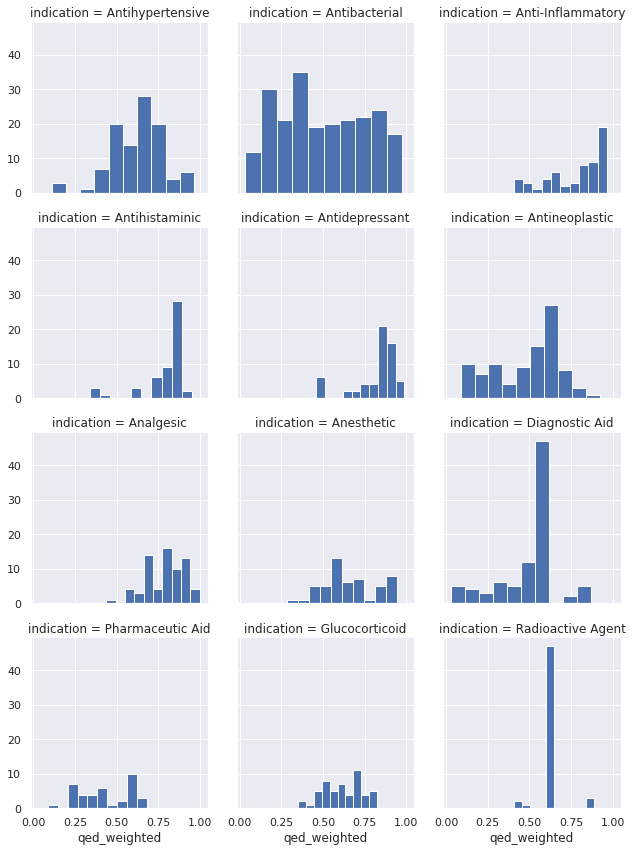

In [147]:
grid = sns.FacetGrid(joined_df, col='indication', col_wrap=3)
grid.map(plt.hist, "qed_weighted")

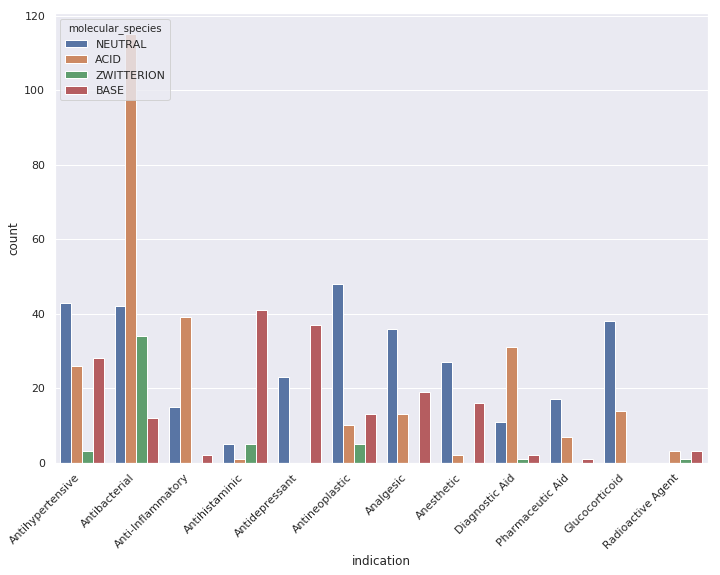

In [152]:
# This is for the one categorical variable, the hue is coloring, a feature, and they are grouped by ind.
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(data=joined_df, x='indication', hue='molecular_species')
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')

In [135]:
joined_df

,chirality,id,acd_logd,acd_logp,acd_most_apka,acd_most_bpka,alogp,aromatic_rings,full_molformula,full_mwt,hba,hbd,heavy_atoms,molecular_species,qed_weighted,indication
0,2,CHEMBL2,0.441410,0.416551,0.662997,0.481097,0.410452,0.375000,C19H21N5O4,0.049982,0.400000,0.100000,0.397059,NEUTRAL,0.769231,Antihypertensive
1,0,CHEMBL4,0.332599,0.403144,0.526372,0.544107,0.397387,0.250000,C18H20FN3O4,0.047079,0.300000,0.100000,0.367647,ACID,0.923077,Antibacterial
2,2,CHEMBL5,0.281938,0.319001,0.432723,0.451446,0.390855,0.250000,C12H12N2O3,0.030068,0.200000,0.100000,0.235294,ACID,0.901099,Antibacterial
3,2,CHEMBL6,0.392952,0.514101,0.460172,0.537443,0.527490,0.375000,C19H16ClNO4,0.046607,0.200000,0.100000,0.352941,ACID,0.813187,Anti-Inflammatory
4,2,CHEMBL8,0.337004,0.392510,0.593111,0.641216,0.399565,0.250000,C17H18FN3O3,0.043124,0.250000,0.200000,0.338235,ZWITTERION,0.945055,Antibacterial
5,2,CHEMBL9,0.320705,0.398058,0.255651,0.641216,0.382689,0.250000,C16H18FN3O3,0.041542,0.250000,0.200000,0.323529,ZWITTERION,0.945055,Antibacterial
6,0,CHEMBL6437,0.383700,0.370319,0.662997,0.610082,0.481219,0.250000,C18H20N2,0.034300,0.100000,0.000000,0.279412,NEUTRAL,0.758242,Antihistaminic
7,2,CHEMBL11,0.453304,0.519186,0.662997,0.701260,0.524769,0.250000,C19H24N2,0.036415,0.100000,0.000000,0.294118,BASE,0.890110,Antidepressant
8,0,CHEMBL406,0.436123,0.408229,0.750269,0.136397,0.426783,0.250000,C16H16ClN3O3S,0.047668,0.200000,0.200000,0.338235,NEUTRAL,0.923077,Antihypertensive
9,0,CHEMBL409,0.531718,0.508553,0.865447,0.537443,0.470332,0.250000,C18H14F4N2O4S,0.056170,0.250000,0.200000,0.411765,NEUTRAL,0.582418,Antineoplastic
